**Overview :** In this notebook, we will predict the percentage of an student based on the no. of study hours.<br>
**Task :-** This is a simple linear regression task as it involves just 2 variables.<br>
**Data Link :** http://bit.ly/w-data<br>
**What we want to Predict-** What will be predicted score if a student studies for 9.25 hrs/ day?

## 1. Importing Libraries

In [1]:
#Data Manipulation libraries
import pandas as pd
import numpy as np

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#scipy library
from scipy.stats import loguniform

#sklearn libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,RepeatedKFold,RandomizedSearchCV

#Miscellaneous library
import warnings
warnings.filterwarnings("ignore")

## 2. Data Understanding

In [2]:
#Loading the data
df = pd.read_csv("http://bit.ly/w-data")

In [3]:
#checking top few rows
df.head()

,Hours,Scores
0,2.5,21
1,5.1,47
2,3.2,27
3,8.5,75
4,3.5,30


In [4]:
#checking the metadata information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
Hours     25 non-null float64
Scores    25 non-null int64
dtypes: float64(1), int64(1)
memory usage: 480.0 bytes


- From above we learnt that we have no null values,Hence data is clean.

In [5]:
#checking the speard of the data
df.describe()

,Hours,Scores
count,25.000000,25.000000
mean,5.012000,51.480000
std,2.525094,25.286887
min,1.100000,17.000000
25%,2.700000,30.000000
50%,4.800000,47.000000
75%,7.400000,75.000000
max,9.200000,95.000000


- From above, we infer following things
    - Total Number of records is 25
    - On an average student scores 51 when he studies for average 5 hrs a day.
    - The Maximum Score for a student is 95 and he studied around 9.25 hrs per day.
    - Minimum Score for a student is 25 where he/she studied approx 1 hr/day.
        

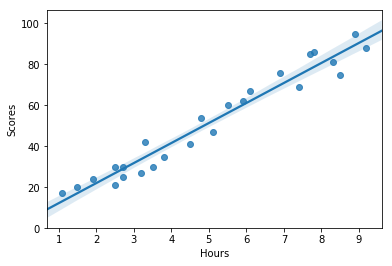

In [6]:
## Lets see how student hours and Scores are correlated
sns.regplot(df.Hours,df.Scores)

- From above we can infer that the number of hrs devoted is proportional to the scores yield.

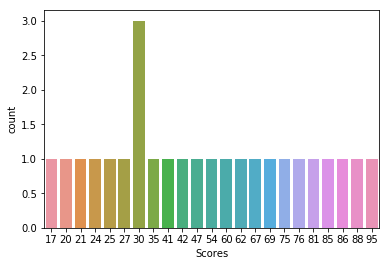

In [7]:
## Lets see count of scores
sns.countplot(df.Scores)

- Out of 25 Students, 3 students Scores 30.

### A. Assumptions of Linear Regression
#### <a> Assumption-1 Linearity


Linear regression needs the relationship between the independent and dependent variables to be linear. Let's use a pair plot to check the relation of independent variables with the Sales variable

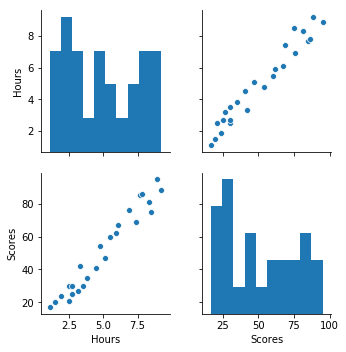

In [8]:
sns.pairplot(df)

- From above we can clearly see that the relationship between independent and dependent variable is linear. Hence Linear Regression Model is good to go here.

## 3. Data Modeling

In [9]:
#Splitting the dependent and independent variable
y = df.pop('Scores')
X= df

In [10]:
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.2,random_state = 42)

## 3.a Linear Regression

In [11]:
#fitting the train data
lr = LinearRegression()
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)

In [12]:
#checking the train score
lr.score(X_train,y_train)

0.9491209376364416

#### <a>Assumption-2 Mean of Residuals

Residuals as we know are the differences between the true value and the predicted value. One of the assumptions of linear regression is that the mean of the residuals should be zero. So let's find out.¶

In [13]:
residuals = y_train-y_train_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals 8.08242361927114e-15


- Its very close to zero, so we are good to go.

#### <a>Assumption-3 Check for Homoscedasticity

Homoscedasticity means that the residuals have equal or almost equal variance across the regression line. By plotting the error terms with predicted terms we can check that there should not be any pattern in the error terms.

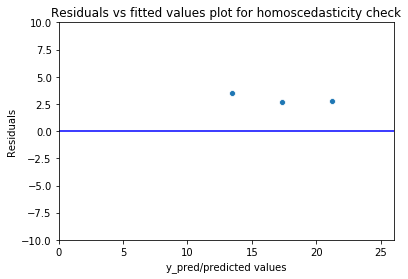

In [14]:
p = sns.scatterplot(y_train_pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

**Now we will be applying tests.**<br>
A tip is to keep in mind that if we want 95% confidence on our findings and tests then the p-value should be less than 0.05 to be able to reject the null hypothesis. <br>_Remember, a researcher or data scientist would always aim to reject the null hypothesis._

#### <a>Goldfeld Quandt Test
Checking heteroscedasticity : Using Goldfeld Quandt we test for heteroscedasticity.

**Null Hypothesis:** Error terms are homoscedastic.<br>
**Alternative Hypothesis:** Error terms are heteroscedastic.

In [15]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 0.6325320293538477), ('p-value', 0.747118645404899)]

**Since p value is more than 0.05 in Goldfeld Quandt Test, we can't reject it's null hypothesis that error terms are homoscedastic.** 

#### <a>Bartlett’s test 
It tests the null hypothesis that all input samples are from populations with equal variances.

In [16]:
from scipy.stats import bartlett
test = bartlett( X_train.values.reshape(-1),residuals)
print(test)

BartlettResult(statistic=10.943739577150858, pvalue=0.0009392041578517814)


**Since p value is quite less than 0.05 in Bartlett, it's null hypothesis that error terms are homoscedastic gets rejected, that's not good for a regression.**

#### <a>Assumption-4 Check for Normality of error terms/residuals

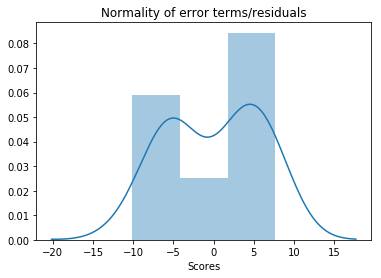

In [17]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

The residual terms are pretty much normally distributed for the number of test points we took. Remember the central limit theorem which says that as the sample size increases the distribution tends to be normal. It's very difficult to get perfect curves, distributions in real life data.

#### <a> Assumption 5 - No autocorrelation of residuals

There should not be autocorrelation in the data so the error terms should not form any pattern.

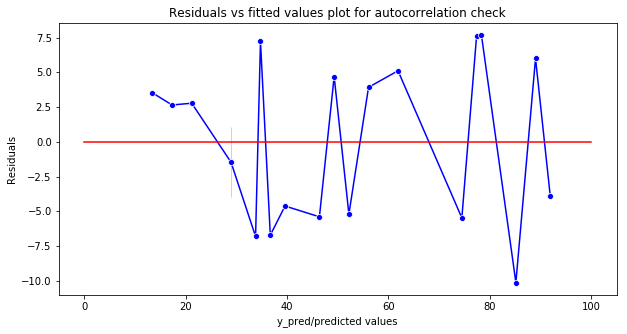

In [18]:
plt.figure(figsize = (10,5))
p = sns.lineplot(y_train_pred,residuals, marker ='o', color ='blue')
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
p = sns.lineplot([0,100],[0,0], color = 'red')
p = plt.title('Residuals vs fitted values plot for autocorrelation check')

- From above we can we that error terms donot find any pattern

### 3.b Prediction on Test Dataset

In [19]:
#predicting on test data
y_pred = lr.predict(X_test)

In [20]:
#checking r2_score
print ("r2/variance : ", lr.score(X_test,y_test))
print("Residual sum of squares: %.2f"
              % np.mean((y_pred - y_test) ** 2))

r2/variance :  0.9678055545167994
Residual sum of squares: 18.94


## 3.c Ridge Regression

In [21]:
#define the model
model = Ridge()
#deine the evaluation
cv = RepeatedKFold(n_splits=5,n_repeats=5,random_state=42)
#define the space search
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
# define search
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -5.284968394636448
Best Hyperparameters: {'alpha': 10, 'fit_intercept': True, 'normalize': False, 'solver': 'svd'}


In [22]:
#checking r2_score
y_pred = search.predict(X_test)
print ("r2/variance : ", r2_score(y_test,y_pred))
print("Residual sum of squares: %.2f"
              % np.mean((y_pred - y_test) ** 2))

r2/variance :  0.9607456697412751
Residual sum of squares: 23.10


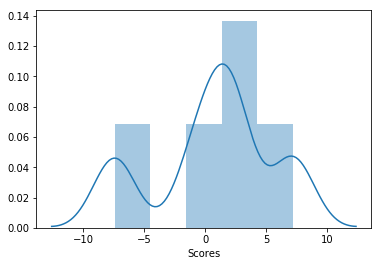

In [23]:
#checking distribution of residuals for ridge
sns.distplot(y_test-y_pred)

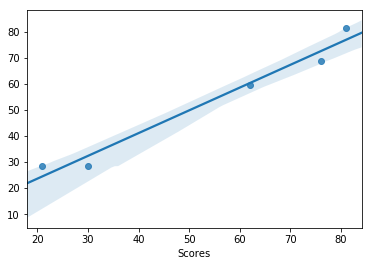

In [24]:
#checking regplot
sns.regplot(y_test,y_pred)

## 3.d Lasso Regression

In [25]:
#define the model
model = Lasso()
#deine the evaluation
cv = RepeatedKFold(n_splits=5,n_repeats=5,random_state=42)
#define the space search
space = dict()
#space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
#space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
# define search
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -5.435683917069558
Best Hyperparameters: {'alpha': 0.1, 'normalize': True}


In [26]:
#checking r2_score
y_pred = result.predict(X_test)
print ("r2/variance : ", r2_score(y_test,y_pred))
print("Residual sum of squares: %.2f"
              % np.mean((y_pred - y_test) ** 2))

r2/variance :  0.9668926021893258
Residual sum of squares: 19.48


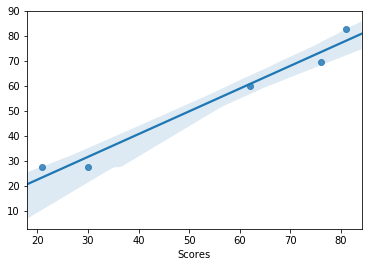

In [27]:
#checking regplot
sns.regplot(y_test,y_pred)

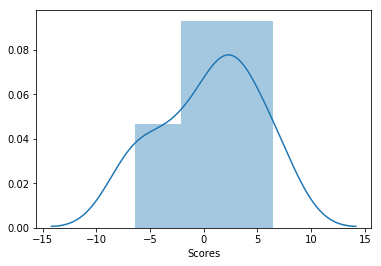

In [28]:
#checking distribution of residuals for lasso
sns.distplot(y_test-y_pred)

## 4. Conclusion
- Normal Linear Regression gives the best prediction
- It satisfies all the Linear Regression Assumption
    - Linearity: The relationship between X and the mean of Y is linear.
    - Homoscedasticity: The variance of residual is the same for any value of X.
    - Independence: Observations are independent of each other.
    - Normality: For any fixed value of X, Y is normally distributed.

### 5. Predicting the Score of student who studies 9.25 hrs per day

In [29]:
print("Score of student who studies 9.25 hrs/per day is ", lr.predict([[9.25]]).ravel())

Score of student who studies 9.25 hrs/per day is  [92.38611528]
